#import every needed Library 


In [ ]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 4.7 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=47ad4382c6cb531f76ed69cf7cfc191a5c950df2ef6e052b1b6bdb9c706c4698
  Stored in directory: /root/.cache/pip/wheels/13/c7/b0/79f66658626032e78fc1a83103690ef6797d551cb22e56e734
Successfully built langdetect


In [ ]:
import nltk
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import warnings
# from langdetect import detect

pd.options.display.max_colwidth = 6000
pd.options.display.max_rows = 400
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
print(tf.__version__)

2.9.2


#loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
CURR_PATH = !pwd
# PARAMETERS
PATH_DATA = CURR_PATH[0]
PATH_GDRIVE_TMP = "/content/drive/MyDrive/ML/project2"  # Google Drive

##detect language 

In [ ]:
def detect2(x):
  try:
    return detect(x)
  except:
    return None

##loading training list

In [ ]:
import pickle
import pandas as pd
with open('/content/drive/MyDrive/ML/project2/listings.pkl', 'rb') as f:
    data = pickle.load(f) 
#combine description
data['Listing Description'] = data['Listing Title'] + '.' + data['Listing Description']
i = data['Listing Description'].isna()
data.loc[i,'Listing Description']= data.loc[i,'Listing Title']

In [ ]:
#language classify
data['Description Langage']=data['Listing Description'].apply(lambda x: detect2(x))
print(len(data))
#save data with language tag
pickle.dump(data, open(PATH_GDRIVE_TMP + "/data_with_language.pkl", "wb"))
data['Description Langage'].value_counts ()

###for building model

In [ ]:
#only use description length more than 100 characters
# data = pickle.load(open(PATH_GDRIVE_TMP+"/data_with_language.pkl", "rb"))
data_de = data.loc[data['Description Langage'] == 'de', ("Listing Description","Listing Title","Demand")]
data_fr = data.loc[data['Description Langage'] == 'fr', ("Listing Description","Listing Title","Demand")]
data_it = data.loc[data['Description Langage'] == 'it', ("Listing Description","Listing Title","Demand")]
print("before filter:",len(data_it))
data_it = data_it[data_it["Listing Description"].apply(len)>100]
print(len(data_de))
print("after filter:",len(data_it))
print(len(data_it))
print(len(data_de)+len(data_fr)+len(data_it))

In [ ]:
data_de.columns = ['description', 'title', 'demand']
data_fr.columns = ['description', 'title', 'demand']
data_it.columns = ['description', 'title', 'demand']
df_de, val_data_de = train_test_split(data_de, test_size=0.2, random_state=19)
df_fr, val_data_fr = train_test_split(data_fr, test_size=0.2, random_state=19)
df_it, val_data_it = train_test_split(data_fr, test_size=0.2, random_state=19)
print(df_de.head(2))
print(df_fr.head(2))
print(df_it.head(2))

##loading testing listing

In [ ]:
import pickle
import pandas as pd

with open('/content/drive/MyDrive/ML/project2/test_listings_overall.pkl', 'rb') as f:
    data = pickle.load(f) 
data['Listing Description'] = data['Listing Title'] + '.' + data['Listing Description']
i = data['Listing Description'].isna()
data.loc[i,'Listing Description']= data.loc[i,'Listing Title']

In [ ]:
data['Description Langage']=data['Listing Description'].apply(lambda x: detect2(x))
print(len(data))
pickle.dump(data, open(PATH_GDRIVE_TMP + "/test_data_with_language.pkl", "wb"))
data['Description Langage'].value_counts ()

###for testing

In [ ]:
data_de = data.loc[data['Description Langage'] == 'de', ("Listing Description","Listing Title","Prediction")]
data_fr = data.loc[data['Description Langage'] == 'fr', ("Listing Description","Listing Title","Prediction")]
data_it = data.loc[data['Description Langage'] == 'it', ("Listing Description","Listing Title","Prediction")]
print("before filter:",len(data_it))
data_it = data_it[data_it["Listing Description"].apply(len)>100]
print(len(data_de))
print("after filter:",len(data_it))
print(len(data_fr))
print(len(data_de)+len(data_fr)+len(data_it))

In [ ]:
data_de.columns = ['description', 'title', 'Prediction']
data_fr.columns = ['description', 'title', 'Prediction']
data_it.columns = ['description', 'title', 'Prediction']
df_de = data_de
df_fr = data_fr
df_it = data_it
print(df_de.head(2))
print(df_fr.head(2))
print(df_it.head(2))

#data processing 

##clean1

*   Converting text to lower-case
*   Standardising representations of a same entity such as “€”, “euro” and “euros” or “m2” and “m²”
*   Cleaning out certain patterns that are unlikely to be meaningful such as URLs, phone numbers, emails and bank account references.



In [ ]:
import re
def treat_euro(text):
    text = re.sub(r'(euro[^s])|(euros)|(€)', ' euros', text)
    return text
def treat_m2(text):
    text = re.sub(r'(m2)|(m²)', ' m²', text)
    return text

In [ ]:
def filter_ibans(text):
    pattern = r'fr\d{2}[ ]\d{4}[ ]\d{4}[ ]\d{4}[ ]\d{4}[ ]\d{2}|fr\d{20}|fr[ ]\d{2}[ ]\d{3}[ ]\d{3}[ ]\d{3}[ ]\d{5}'
    text = re.sub(pattern, '', text)
    return text
def remove_space_between_numbers(text):
    text = re.sub(r'(\d)\s+(\d)', r'\1\2', text)
    return text
def filter_emails(text):
    pattern = r'(?:(?!.*?[.]{2})[a-zA-Z0-9](?:[a-zA-Z0-9.+!%-]{1,64}|)|\"[a-zA-Z0-9.+!% -]{1,64}\")@[a-zA-Z0-9][a-zA-Z0-9.-]+(.[a-z]{2,}|.[0-9]{1,})'
    text = re.sub(pattern, '', text)
    return text
def filter_ref(text):
    pattern = r'(\(*)(ref|réf)(\.|[ ])\d+(\)*)'
    text = re.sub(pattern, '', text)
    return text
def filter_websites(text):
    pattern = r'(http\:\/\/|https\:\/\/)?([a-z0-9][a-z0-9\-]*\.)+[a-z][a-z\-]*'
    text = re.sub(pattern, '', text)
    return text
def filter_phone_numbers(text):
    pattern = r'(?:(?:\+|00)33[\s.-]{0,3}(?:\(0\)[\s.-]{0,3})?|0)[1-9](?:(?:[\s.-]?\d{2}){4}|\d{2}(?:[\s.-]?\d{3}){2})|(\d{2}[ ]\d{2}[ ]\d{3}[ ]\d{3})'
    text = re.sub(pattern, '', text)
    return text
def filter_tag(text):
    pattern = r'<[^>]+>'
    text = re.sub(pattern, '', text)
    return text

In [ ]:
def clean_text(text):
    text = text.lower()
    text = text.replace(u'\xa0', u' ')
    text = treat_m2(text)
    text = treat_euro(text)
    text = filter_phone_numbers(text)
    text = filter_emails(text)
    text = filter_ibans(text)
    text = filter_ref(text)
    text = filter_websites(text)
    text = remove_space_between_numbers(text)
    text = filter_tag(text)
    return text
df_it['cleaned_description'] = df_it.description.apply(clean_text)

##clean2 
only in case of dealing stop word (which is not necessary in this task)

###for french

In [ ]:
nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("french")
stop_words = set(stopwords.words("french"))


def clean_text_fr(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

df_fr['cleaned_description'] = df_fr.description.apply(clean_text_fr)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


###for Italian

In [ ]:
nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("italian")
stop_words = set(stopwords.words("italian"))


def clean_text_it(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

df_it['cleaned_description'] = df_it.description.apply(clean_text_it)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


###for german

In [ ]:
nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))

def clean_text_de(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

df_de['cleaned_description'] = df_de.description.apply(clean_text_de)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#Italian model

##Tokenization

In [ ]:
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 28.5 MB/s 
     |████████████████████████████████| 182 kB 102.1 MB/s 
     |████████████████████████████████| 7.6 MB 89.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 24.2 MB/s 


In [ ]:
from transformers import AutoModel, AutoTokenizer

In [ ]:
model_name = "dbmdz/bert-base-italian-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/235k [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
encoded_corpus = tokenizer(text=df_it.cleaned_description.tolist(),
                            add_special_tokens=True,
                            padding='max_length',
                            truncation='longest_first',
                            max_length=300,
                            return_attention_mask=True)
input_ids = encoded_corpus['input_ids']
attention_mask = encoded_corpus['attention_mask']

In [ ]:
import numpy as np
def filter_long_descriptions(tokenizer, descriptions, max_len):
    indices = []
    lengths = tokenizer(descriptions, padding=False, 
                     truncation=False, return_length=True)['length']
    for i in range(len(descriptions)):
        if lengths[i] <= max_len-2:
            indices.append(i)
    return indices
short_descriptions = filter_long_descriptions(tokenizer, 
                               df_it.cleaned_description.tolist(), 300)
input_ids = np.array(input_ids)[short_descriptions]
attention_mask = np.array(attention_mask)[short_descriptions]
labels = df_it.demand.to_numpy()[short_descriptions]

Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors


##Input formatting

###for train

In [ ]:
from sklearn.model_selection import train_test_split
test_size = 0.1
seed = 42
train_inputs, test_inputs, train_labels, test_labels = \
            train_test_split(input_ids, labels, test_size=test_size, 
                             random_state=seed)
train_masks, test_masks, _, _ = train_test_split(attention_mask, 
                                        labels, test_size=test_size, 
                                        random_state=seed)

###for testing

In [ ]:
train_inputs = input_ids
train_masks = attention_mask

##create_dataloaders

###train dataloader

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
batch_size = 32
def create_dataloaders(inputs, masks, labels, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(input_tensor, mask_tensor, 
                            labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                            shuffle=True)
    return dataloader
train_dataloader = create_dataloaders(train_inputs, train_masks, 
                                      train_labels, batch_size)
test_dataloader = create_dataloaders(test_inputs, test_masks, 
                                     test_labels, batch_size)

###test dataloader

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
batch_size = 32
def create_dataloaders(inputs, masks, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    dataset = TensorDataset(input_tensor, mask_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                            shuffle=True)
    return dataloader
train_dataloader = create_dataloaders(train_inputs, train_masks, batch_size)

##Implementing the model in PyTorch

In [ ]:
import torch.nn as nn
from transformers import AutoModel
class AutoRegressor(nn.Module):
    
    def __init__(self, drop_rate=0.2):
        
        super(AutoRegressor, self).__init__()
        D_in, D_out = 768, 1
        self.auto = \
                   AutoModel.from_pretrained(model_name)
        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(D_in, D_out))
    def forward(self, input_ids, attention_masks):
        
        outputs = self.auto(input_ids, attention_masks)
        class_label_output = outputs[1]
        outputs = self.regressor(class_label_output)
        return outputs
model = AutoRegressor(drop_rate=0.2)

Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


##Setting up the training environment

In [ ]:
import torch
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")
model.to(device)

Using GPU.


AutoRegressor(
  (auto): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

##Optimizer, scheduler and loss function

In [ ]:
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr=5e-5,
                  eps=1e-8)

In [ ]:
from transformers import get_linear_schedule_with_warmup
epochs = 20
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,       
                 num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
loss_function = nn.MSELoss()
# loss_function = nn.PoissonNLLLoss()

##Training loop

In [ ]:
from torch.nn.utils.clip_grad import clip_grad_norm
def train(model, optimizer, scheduler, loss_function, epochs,       
          train_dataloader, device, clip_value=2):
    for epoch in range(epochs):
        print(epoch)
        print("-----")
        best_loss = 1e10
        model.train()
        for step, batch in enumerate(train_dataloader): 
            print(step)  
            batch_inputs, batch_masks, batch_labels = \
                               tuple(b.to(device) for b in batch)
            model.zero_grad()
            outputs = model(batch_inputs, batch_masks)           
            loss = loss_function(outputs.squeeze().float(), 
                             batch_labels.squeeze().float())
            print(f'step:{step}, loss:{loss}') 
            loss.backward()
            clip_grad_norm(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()
                
    return model
model = train(model, optimizer, scheduler, loss_function, epochs, 
              train_dataloader, device, clip_value=2)

0
-----
0
step:0, loss:43.99493408203125
1
step:1, loss:35.7918701171875
2
step:2, loss:43.37897491455078
3
step:3, loss:29.97772789001465
4
step:4, loss:32.8875732421875
5
step:5, loss:53.414337158203125
6
step:6, loss:42.72531509399414
7
step:7, loss:29.150680541992188
8
step:8, loss:30.906400680541992
9
step:9, loss:69.45500946044922
10
step:10, loss:87.06778717041016
11
step:11, loss:17.817630767822266
12
step:12, loss:37.267887115478516
13
step:13, loss:19.46951675415039
14
step:14, loss:22.751968383789062
15
step:15, loss:17.967653274536133
16
step:16, loss:47.05247497558594
17
step:17, loss:10.01845932006836
18
step:18, loss:42.75469207763672
19
step:19, loss:46.242095947265625
20
step:20, loss:76.14486694335938
21
step:21, loss:71.57670593261719
22
step:22, loss:13.281845092773438
23
step:23, loss:120.5060806274414
24
step:24, loss:16.037946701049805
25
step:25, loss:162.13548278808594
26
step:26, loss:21.116182327270508
27
step:27, loss:17.136558532714844
28
step:28, loss:23.2

#Performance

In [ ]:
def predict(model, dataloader, device):
    model.eval()
    output = []
    for batch in dataloader:
        batch_inputs, batch_masks, _ = \
                                  tuple(b.to(device) for b in batch)
        with torch.no_grad():
            output += model(batch_inputs, 
                            batch_masks).view(1,-1).tolist()[0]
    return output

def r2_score(outputs, labels):
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [ ]:
val_set = val_data_it[['description', 'demand']]
val_set['cleaned_description'] = \
                val_set.description.apply(clean_text)
encoded_val_corpus = \
                tokenizer(text=val_set.cleaned_description.tolist(),
                          add_special_tokens=True,
                          padding='max_length',
                          truncation='longest_first',
                          max_length=300,
                          return_attention_mask=True)
val_input_ids = np.array(encoded_val_corpus['input_ids'])
val_attention_mask = np.array(encoded_val_corpus['attention_mask'])
val_labels = val_set.demand.to_numpy()
# val_labels = price_scaler.transform(val_labels.reshape(-1, 1))
val_dataloader = create_dataloaders(val_input_ids, 
                         val_attention_mask, val_labels, batch_size)
# y_pred_scaled = predict(model, val_dataloader, device)
y_pred = predict(model, val_dataloader, device)
y_test = val_set.demand.to_numpy()

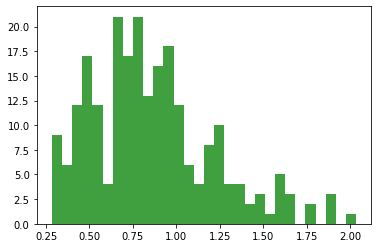

In [ ]:
import matplotlib.pyplot as plt
# n = data["comment_clean"].str.len()
nn, bins, patches = plt.hist(y_pred, 30, facecolor ='g', alpha=0.75)
plt.show()

###mean pisson deviance

In [ ]:
def custom_poisson_deviance(y_true,y_pred):
  prediction=y_pred.copy()
  prediction = np.array(prediction)
  prediction[np.where(prediction==0)]=10**(-10)
  return mean_poisson_deviance(y_true,prediction)
from sklearn.metrics import mean_poisson_deviance
custom_poisson_deviance(y_test, y_pred)

8.000836979970725

#test listing prediction

In [ ]:
def predict(model, dataloader, device):
    model.eval()
    output = []
    for batch in dataloader:
        batch_inputs, batch_masks = \
                                  tuple(b.to(device) for b in batch)
        with torch.no_grad():
            output += model(batch_inputs, 
                            batch_masks).view(1,-1).tolist()[0]
    return output

def r2_score(outputs, labels):
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2
y_pred = predict(model, train_dataloader, device)

In [ ]:
df_it["Prediction"] = y_pred

#fill data

In [ ]:
data = pd.read_csv(PATH_GDRIVE_TMP + "/test_overall_data_with_prediction_WN.csv")
# data = pd.read_csv(PATH_GDRIVE_TMP + "/test_overall_data_with_prediction_NN.csv")

In [ ]:
data.loc[df_it.index, "Prediction"] = df_it["Prediction"]

In [ ]:
pickle.dump(data, open(PATH_GDRIVE_TMP + "/test_data_with_prediction_WN.pkl", "wb"))
data.to_csv(PATH_GDRIVE_TMP+"/test_overall_data_with_prediction_WN.csv", index=False)

In [ ]:
# pickle.dump(data, open(PATH_GDRIVE_TMP + "/test_overall_data_with_prediction_NN.pkl", "wb"))
# data.to_csv(PATH_GDRIVE_TMP+"/test_overall_data_with_prediction_NN.csv", index=False)

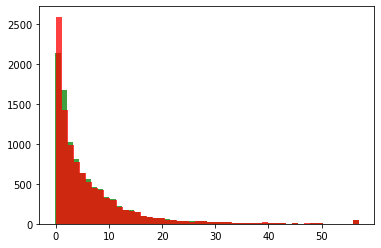

In [ ]:
nn, bins, patches = plt.hist(data["Prediction"],50, facecolor ='g', alpha=0.75)
 = data.copy()
d1.loc[d1["Prediction"]<0,"Prediction"] = 0
nn, bins, patches = plt.hist(d1["Prediction"],50, facecolor ='r', alpha=0.75)
plt.show()